In [1]:
from datetime import datetime
import fsspec
import matplotlib
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import re
import geopy.distance
from matplotlib.ticker import MultipleLocator

import xarray as xr
from scipy.ndimage import gaussian_filter
from ormhw.core import NH_LINE, CE01, CE02, CE04, FIGURE_DIR
from ormhw.gebco import import_gebco
from ormhw.core import BoundingBox

In [2]:
years = range(2015,2024)
figsize = (3,3)
dpi = 600
filename = 'chl_gradient'
filetype = 'jpg'
matplotlib.rcParams.update({'font.size': 8})

In [3]:
oc = xr.open_dataset('/home/jovyan/data/nasa/oc_2015-2023.nc')
#oc = oc.sel(lon = slice(-128,CE01.lat))
oc = oc.sel(latitude = NH_LINE.lat, method = 'nearest')

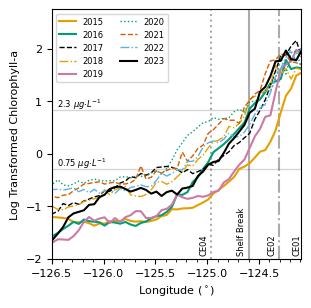

In [4]:
fig, ax = plt.subplots(1,1, figsize = figsize, constrained_layout = True)
plt_colors = [(230,159,0), (0,158,115),(0,0,0),(230,159,0),(204,121,167), (0,158,115),(213,94,0),(86,180,233),(0,0,0)]
plt_width = [1.5,1.5,1,1,1.5,1,1,1,1.5]
plt_styles = ['-', '-','--','-.','-',':','--', '-.','-']

for year in years:
    idx = years.index(year)
    subds = oc.sel(time = slice(datetime(year,7,9),datetime(year,10,8,23,59,59)))
    subds = subds[['chl']].mean(dim = 'time')
    new_lons = np.arange(subds.longitude.min(), subds.longitude.max(), 0.05)
    _interp = subds.interp({'longitude': new_lons})
    
    
    # lon = subds.lon
    # logchl = np.log(subds.chl)  
    # ax.plot(lon, logchl, label = str(year), color = [v/255 for v in plt_colors[idx]], linewidth = plt_width[idx],linestyle = plt_styles[idx])

    
    
    lon = _interp.longitude
    logchl = np.log(_interp.chl)  
    ax.plot(lon, logchl, label = str(year), color = [v/255 for v in plt_colors[idx]], linewidth = plt_width[idx],linestyle = plt_styles[idx])

ax.set_xlim(-126.5,CE01.lon)
ax.set_ylim(-2,2.75)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_box_aspect(1)


ax.axhline(np.log(0.75), linestyle = '-', color = 'gray', alpha = 0.33, linewidth = 1, zorder = 0)
plt.text(-126.45,round(np.log(0.75),2) + 0.05, r'$0.75\ {\mu}g{\cdot}L^{-1}$', fontsize = 6)



ax.axhline(np.log(2.3), linestyle = '-', color = 'gray', alpha = 0.33, linewidth = 1, zorder = 0)
plt.text(-126.45,round(np.log(2.3),2) + 0.05,r'$2.3\ {\mu}g{\cdot}L^{-1}$', fontsize = 6)

ax.axvline(CE04.lon, linestyle = ':', color = 'black', alpha = 0.33, zorder = 0)
plt.text(CE04.lon - 0.11,-1.9,'CE04', rotation = 90, fontsize = 6)


ax.axvline(CE02.lon, linestyle = 'dashdot', color = 'black', alpha = 0.33, zorder = 0)
plt.text(CE02.lon - 0.11,-1.9,'CE02', rotation = 90, fontsize = 6)


ax.axvline(-124.6, linestyle = '-', color = 'black', alpha = 0.33, zorder = 0)
plt.text(-124.6 - 0.11,-1.9,'Shelf Break', rotation = 90, fontsize = 6)


plt.text(CE01.lon - 0.08,-1.9,'CE01', rotation = 90, fontsize = 6)


ax.set_xlabel(r'Longitude ($^\circ$)')
ax.set_ylabel('Log Transformed Chlorophyll-a')
ax.legend(loc = 'upper left', ncol = 2, fontsize = 6)

plt.savefig(f'/home/jovyan/oregon-shelf-mhw/figures/{filename}.{filetype}', dpi = dpi)


## LaTeX Output

In [8]:
print('Year', '&', r'$0.75\ {\mu}g{\cdot}L^{-1}$', '&', r'$2.3\ {\mu}g{\cdot}L^{-1}$', r'\\\\', "\hline")

for year in years: 
    _oc = oc.sel(time = slice(datetime(year,7,9),datetime(year,10,8,23,59,59)))
    _oc = _oc[['chl']].mean(dim = 'time')

    yriso1 = _oc.where((_oc.chl-0.75 <= 0 ), drop = True).longitude.max()
    delta1 = geopy.distance.geodesic((44.652,-124.6), (44.652, yriso1.values)).km
    if yriso1.values > -124.6:
        delta1 = -1 * delta1
    
    
    yriso2 = _oc.where((_oc.chl-2.3 <- 0 ), drop = True).longitude.max()    
    delta2 =  geopy.distance.geodesic((44.652,-124.6), (44.652, yriso2.values)).km
    if yriso2.values > -124.6:
        delta2 = -1 * delta2
        
    delta1 = round(delta1)
    delta2 = round(delta2)

    
    if delta1 > 0:
        d1 = f"+{delta1}"
    else:
        d1 = delta1
    if delta2 > 0:
        d2 = f"+{delta2}"
    else:
        d2 = delta2
        
    print(year,'&',d1,'&', d2, '\\\\')


Year & $0.75\ {\mu}g{\cdot}L^{-1}$ & $2.3\ {\mu}g{\cdot}L^{-1}$ \\\\ \hline
-24.590008375174712
2015 & +6 & -25 \\
0.7932265551574634
2016 & +35 & +1 \\
-8.725491436981848
2017 & +35 & -9 \\
2.3796796513146923
2018 & +49 & +2 \\
-18.244204702946273
2019 & +9 & -18 \\
1.586453106219771
2020 & +63 & +2 \\
3.966132711667595
2021 & +57 & +4 \\
-6.3458121806262655
2022 & +51 & -6 \\
-3.17290618523561
2023 & +34 & -3 \\


<>:1: SyntaxWarning: invalid escape sequence '\h'
<>:1: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_2068/1497484463.py:1: SyntaxWarning: invalid escape sequence '\h'
  print('Year', '&', r'$0.75\ {\mu}g{\cdot}L^{-1}$', '&', r'$2.3\ {\mu}g{\cdot}L^{-1}$', r'\\\\', "\hline")
